**Intro**

Hello everyone. This notebook goes through how to train an AI to differentiate between healthy lungs, bacterial pneumonia, and viral pneumonia using transfer learning with vgg16, a neural network which was trained on millions of images and excels at classification. As you might have already guessed if you saw the date of this notebook, my selection of this topic was largely influced by the ongoing pandemic at the time I'm writing this. The original plan was to train one to diagnose Covid19, but due to the lack of data, I decided to use viral pneumonia instead, seeing that Covid19 is a virus that causes pneumonia. Even without the context of this pandemic AI will become essential in the medical field, as some diseases that are almost impossible to distinguish with the naked eye can be rather easily diagonsed with a well trained AI. Therefore, every step of progress we make, no matter how small, could lead to a huge diffrence in lives saved. However, my personal reason for creating this notebook was to learn and hopefully teach others what I gained from creating this.

For some context, you likely will need to have some basic knowledge about AI in order to follow along. I'm not a teacher or any sort of professional that is qualified to teach you that stuff, so google it or go take a class online if you don't understand the context. In fact, I'm just a highschooler that took one class about AI over the summer and decided to try my hand at it. That being said, I would credit NAIN and his notebook (https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution). Due to my lack of experience, I used this as a basis for my notebook. The main difference is that he is distinguishing between health and pneumonia striken lungs while mine also deals with bacterial vs viral pneumonia. He did a great job with his notebook so you should go check him out later.

In [1]:
#import stuff
import os
import glob
import h5py
import shutil
import imgaug as aug #augment data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt #plot stuff/show images
import matplotlib.image as mimg
import imgaug.augmenters as iaa #augment data(data is imbalanced)
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path #get data
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input #transfer learning
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
#convolutional nueral networks
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline
print(os.listdir("../input"))

['vgg16', 'pneumonia-virus-vs-covid19', 'covid19-detection-xray-dataset', 'covid19-radiography-database', 'chest-xray-pneumonia']


You must use your GPU or else training will take a year. In order to do that, at the top right of your notebook, you will see bars that show your HDD, CPU, and RAM usage. To the right of that you will see 3 vertical darts. Click on that, click on "Accelerator", and select "GPU". Then run the code below. It will error if it can't find your GPU. If so, good luck.

In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.config.experimental.list_physical_devices('GPU')

Found GPU at: /device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

The code below will get the directories to the data. The data we will be using consists of .jpeg images of chest X-rays taken from the front.

In [3]:
#get data
data_dir1 = Path('../input/chest-xray-pneumonia/chest_xray/chest_xray')
data_dir2 = Path('../input/covid19-detection-xray-dataset')
data_dir3 = Path('../input/covid19-radiography-database/COVID-19 Radiography Database')
data_dir4 = Path('../input/pneumonia-virus-vs-covid19/Pneumonia_and_COVID19')

Here we will initialize the lists that we will store our data in.

In [4]:
data = []
normal_data = []
bacterial_data = []
viral_data = []

Load data in from the first dataset. As of now, we are not sperating the data into training, test, and validation, but into different lists based on the diagnosis. We will also be assigning a number to each label: 0 for health, 1 for bacterial pneumonia, and 2 for viral pneumonia.

In [5]:
loop_dir1 = ['test', 'train', 'val']
for i in loop_dir1:
    normal_dir1 = data_dir1 / i / 'NORMAL'
    pneumonia_dir1 = data_dir1 / i / 'PNEUMONIA'
    normal_cases1 = normal_dir1.glob('*.jpeg')
    pneumonia_cases1 = pneumonia_dir1.glob('*.jpeg')
    for img in normal_cases1:
        normal_data.append((img,0))
    for img in pneumonia_cases1:
        if "bacteria" in str(img):
            bacterial_data.append((img,1))
        elif "virus" in str(img):
            viral_data.append((img,2))
    

Load data from the second dataset. You will notice the code is diffrent. This is due to the fact that each dataset is formated diffrently so we have to navigate through diffrent folders.

In [6]:
loop_dir2 = ['NonAugmentedTrain', 'ValData']
for i in loop_dir2:
    normal_dir2 = data_dir2 / i / 'Normal'
    bacterial_dir2 = data_dir2 / i / 'BacterialPneumonia'
    viral_dir2 = data_dir2 / i / 'ViralPneumonia'
    normal_cases2 = normal_dir2.glob('*.jpeg')
    bacterial_cases2 = bacterial_dir2.glob('*.jpeg')
    viral_cases2 = viral_dir2.glob('*.jpeg')
    for img in normal_cases2:
        normal_data.append((img,0))
    for img in bacterial_cases2:
        bacterial_data.append((img,1))
    for img in viral_cases2:
        viral_data.append((img,2))

This is a work in progress. In order to use it I need to convert all the .png images into .jpeg (or maybe I don't? Please comment if you know). These images are higher quality than the last dataset, but maybe introducing some poorer images into the dataset isn't a bad idea.

In [7]:
# normal_dir3 = data_dir3 / 'NORMAL'
# viral_dir3 = data_dir3 / 'Viral Pneumonia'
# normal_cases3 = normal_dir3.glob('*.png')
# viral_cases3 = viral_dir3.glob('*.png')
# for i, img in enumerate(normal_cases3):
#     im = Image.open(img)
#     rgb_img = im.convert('RGB')
#     rgb_img.save('normal('+str(i)+').jpeg', quality=100, subsampling = 0)
#     data.append((rgb_img,0))
# for i, img in enumerate(viral_cases3):
#     im = Image.open(img)
#     rgb_img = im.convert('RGB')
#     rgb_img.save('viral('+str(i)+').jpeg', quality=100, subsampling = 0)
#     data.append((rgb_img,2))
    
    
# for img in normal_cases2:
#     rgb_img = cv2.imread(img)
#     cv2.imwrite(img[:-3] + 'jpeg', rgb_img)
#     data.append((img,0))
# for img in viral_cases2:
#     rgb_img = cv2.imread(img)
#     cv2.imwrite(img[:-3] + 'jpeg', rgb_img)
#     data.append((img,2))

Load data from the last dataset. It only has viral pneumonia because that was the only data we were lacking enough of.

In [8]:
loop_dir4 = ['TEST', 'TRAIN']
for i in loop_dir4:
    viral_dir4 = data_dir4 / i / 'PNEUMONIA (VIRUS)'
    viral_cases4 = viral_dir4.glob('*.jpeg')
    for img in viral_cases4:
        viral_data.append((img,2))

This checks the numbers of each label.

In [9]:
print('number of normal cases: ' + str(len(normal_data)))
print('number of bacterial cases: ' + str(len(bacterial_data)))
print('number of viral cases: ' + str(len(viral_data)))

number of normal cases: 2913
number of bacterial cases: 3754
number of viral cases: 3603


Combine all data into one list. You might think this is redundent and we should have just loaded them into one list in the first place. You would be correct. However, loading them into seperate lists would have allowed us to trim off execess data if the data was imbalanced. For example, if we had far too many bacterial pneumonia cases we could just only use an amount that is equal to the other 2 cases.

In [10]:
data = normal_data + bacterial_data + viral_data
del normal_data, bacterial_data, viral_data, data_dir1, data_dir2, data_dir3, data_dir4

Convert to dataframe and shuffle.

In [11]:
data = pd.DataFrame(data, columns=['image', 'label'],index=None)
#shuffle
data = data.sample(frac=1.).reset_index(drop=True)
#print
data.head()        

,image,label
0,../input/covid19-detection-xray-dataset/ValDat...,1
1,../input/chest-xray-pneumonia/chest_xray/chest...,2
2,../input/chest-xray-pneumonia/chest_xray/chest...,1
3,../input/chest-xray-pneumonia/chest_xray/chest...,2
4,../input/covid19-detection-xray-dataset/NonAug...,0


Some data visualization.

1    3754
2    3603
0    2913
Name: label, dtype: int64


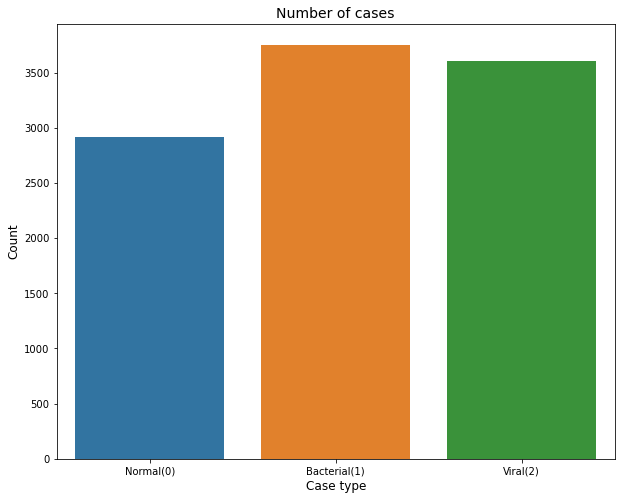

In [12]:
# Get the counts for each class
cases_count = data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Bacterial(1)', 'Viral(2)'])
plt.show()
del cases_count

This will allow use to see some of the images with their respective labels. Here you might notice that sometimes it is nearly impossible to tell the difference between a healthy lung and a pneumonia striken one, not to mention the difference between the types of pneumonia.

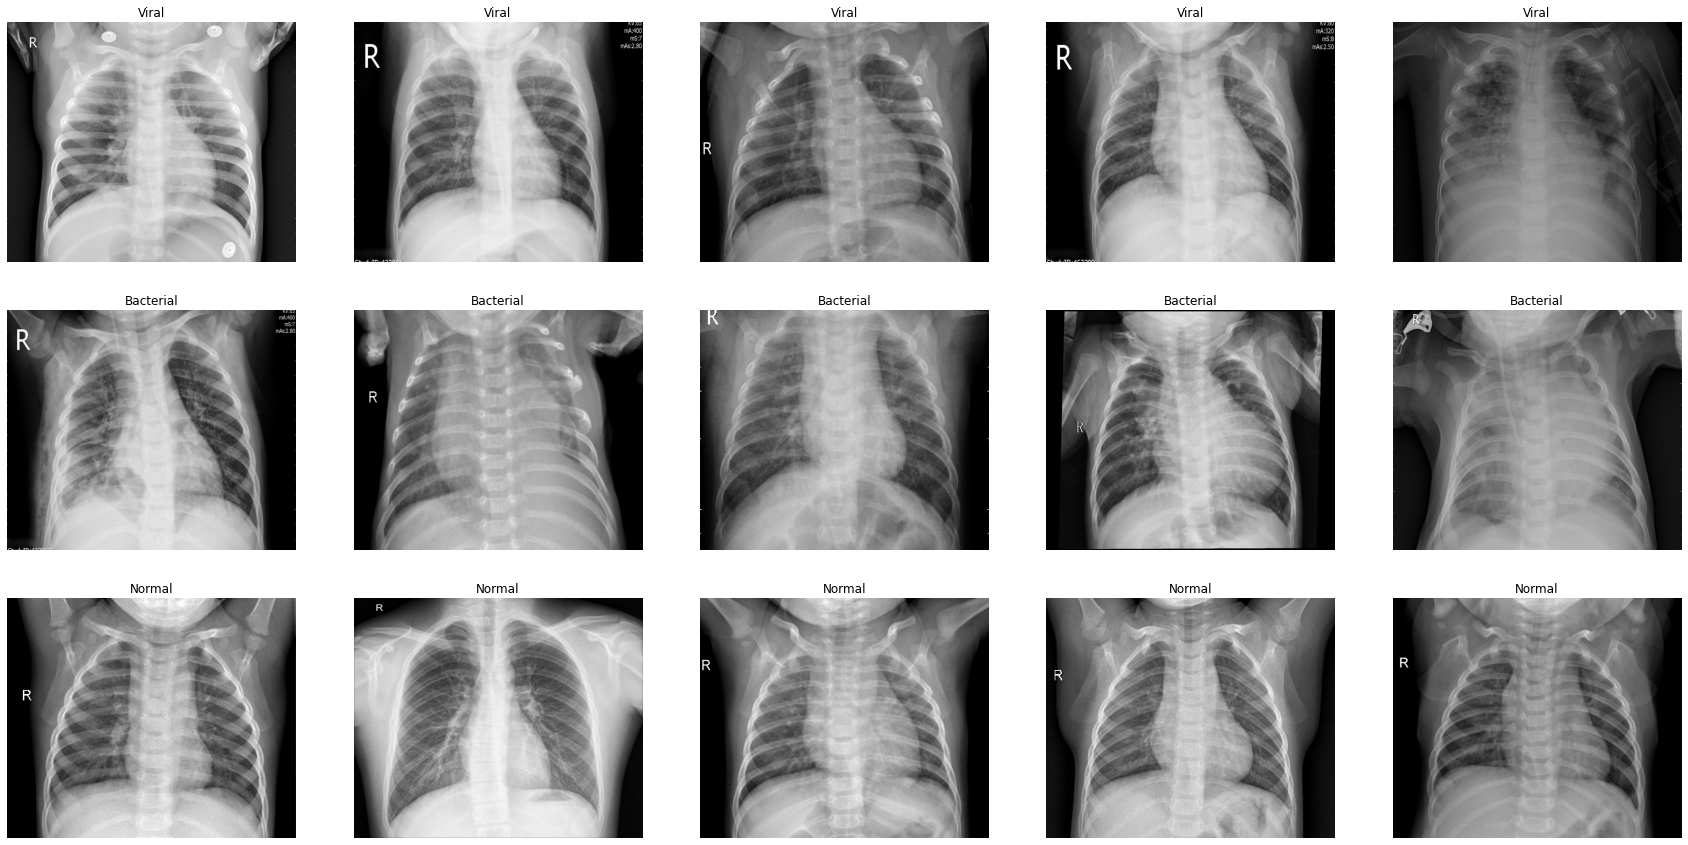

In [13]:
#show sample
viral_samples = (data[data['label']==2]['image'].iloc[:5]).tolist()
bacterial_samples = (data[data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (data[data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above 3 lists
samples = viral_samples + bacterial_samples + normal_samples
del viral_samples, normal_samples, bacterial_samples

# Plot the data 
f, ax = plt.subplots(3,5, figsize=(30,15))
for i in range(15):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Viral")
    elif i>=5 and i<10:
        ax[i//5, i%5].set_title("Bacterial")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

Unfortunately, when I tried to train the AI, the notebook ran out of memory. Therefore, I am forced to only use half the data. The circumstances might be different for you though, so good luck. This is also why I kept deleteing every variable I wasn't using again.

In [14]:
data = data.iloc[: int(data.shape[0]/2)]
print(data.shape)

(5135, 2)


Up until now, the data has just been the path to the image instead of the image itself. This code actually gets us the image itself and loads the images and labels into seperate arrays. vgg16 takes colored images that have the dimensions of (224, 224, 3) with the numbers representing each pixel ranging from 0 to 1. This code takes care of that by resizing the images, turning grayscale images(they only have 1 layer so we need to convert them) into colored ones (which have 3 layers), and setting all images to the same color so color won't be a confounding variable.

In [15]:
image_data = []
label_data = []
for index, d in data.iterrows():
    img = d['image']
    l = d['label']
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(l, num_classes=3)
    image_data.append(img)
    label_data.append(label)
image_data = np.array(image_data)
label_data = np.array(label_data)
del data

Here we finally split the data into training, validation, and test.

In [16]:
image_train, image_validate, image_test = np.split(image_data, [int(.7*len(image_data)), int(.85*len(image_data))])
label_train, label_validate, label_test = np.split(label_data, [int(.7*len(label_data)), int(.85*len(label_data))])
print('number of training images and labels: ' + str(len(image_train)) + ' and ' + str(len(label_train)))
print('number of validation images and labels: ' + str(len(image_validate)) + ' and ' + str(len(label_validate)))
print('number of test images and labels: ' + str(len(image_test)) + ' and ' + str(len(label_test)))
del image_data, label_data

number of training images and labels: 3594 and 3594
number of validation images and labels: 770 and 770
number of test images and labels: 771 and 771


**Model Time**

As stated earlier, we will be using transfer learning. For a quick recap of what transfer learing is, we basically take a pre-trained model and repurpose it to do our task. Said model would have already aquired a wealth of information, which would make it better than an entirely new model. It's like how teaching a adult to do something is usually easier than teaching a baby to do the same thing. More info: https://machinelearningmastery.com/transfer-learning-for-deep-learning/

In this case, we will be using "vgg16", a model that has been trained to do image classification. More info: https://neurohive.io/en/popular-networks/vgg16/

In order to do this, I imported the model and replaced the output layer with on of my own (3 classes instead of the original 1k). You can uncomment the last line to output the structure of the model but I was afraid of memory issues.

In [17]:
from keras.applications.vgg16 import VGG16
vgg16_weights = '../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
vgg16_model = VGG16(weights=vgg16_weights)
new_vgg16 = Sequential()
for layer in vgg16_model.layers[:-1]:
    new_vgg16.add(layer)
new_vgg16.add(Dense(3, activation='softmax'))
del vgg16_model, vgg16_weights
#new_vgg16.summary()


You should probably google this. It's a lot of math that I don't have the space to explain.

loss: https://gombru.github.io/2018/05/23/cross_entropy_loss/

optimizer: https://algorithmia.com/blog/introduction-to-optimizers

metrics: https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

If you want my TLDR explanation of this: 

Loss is basically error. You want this as low as possible. You use categorical crossentropy to calculate it when dealing with multiple labels and binary crossentropy for only 2. 

An optimizer is kind of like the pilot. It decides when to change the weights, by how much, etc. Diffrent optimizers will be suited for diffrent tasks. We will be using Adam.

Metrics are what you measure your model by. This is usually accuracy but might change depending on your task.

In [18]:
new_vgg16.compile(loss='categorical_crossentropy',
              optimizer= Adam(lr=0.0001, decay=1e-5),
              metrics=['accuracy'])

This code will basically stop the training if the model starts getting worse. That never happened, but the important part is "restore_best_weights=True". This means that it will return us the best version of the model, as graded by validation accuracy.

In [19]:
early_stopping_monitor = EarlyStopping(
    monitor='val_acc',
    min_delta=0,
    patience=4,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

This is where I train the model. A batch size of 16 means the model only updates its weights every 16 images. This helps prevent overfitting which is bad: https://elitedatascience.com/overfitting-in-machine-learning

Epochs are the number of times the model goes through the data and the validation data is there to test the effectiveness of the model. You can also see here that I set verbose to 0. It is 1 by defult and prints out progress bars and metrics for each iteration of the model. I silenced it because it caused memory issues.

In [20]:
batch_size = 16
with tf.device('/gpu:0'):
    new_vgg16.fit(image_train, label_train, \
                    validation_data=(image_validate, label_validate), \
                    epochs=20, callbacks=[early_stopping_monitor], batch_size=batch_size, verbose = 0)


This pits our algorithim against the test data. You should hopefully get an accuracy of around 85% and a loss of around .7.

In [21]:
test_loss, test_score = new_vgg16.evaluate(image_test, label_test, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

49/49 [==============================] - 2s 48ms/step - loss: 0.6159 - accuracy: 0.8482
Loss on test set:  0.6158562302589417
Accuracy on test set:  0.8482490181922913


However, 84% accuracy is kind of low for something that used transfer learing for a relatively basic task. The next two blocks will allow us to see the predictions that were made.

In [22]:
# Get predictions
preds = new_vgg16.predict(image_test, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(label_test, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(771,)
(771,)


<Figure size 432x288 with 0 Axes>

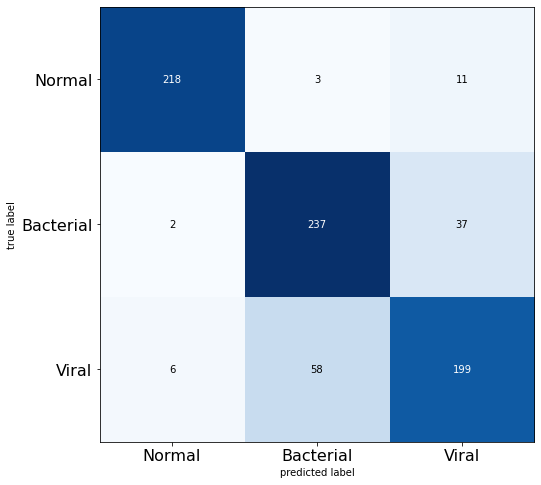

In [23]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'Bacterial', 'Viral'], fontsize=16)
plt.yticks(range(3), ['Normal', 'Bacterial', 'Viral'], fontsize=16)
plt.show()

As some of you might have suspected, it turns out that bacterial pneumonia and viral pneumonia are relatively similar, even to an AI. However, our predictions on which lungs were healthy were phenominal.

Below is some more data analysis. Here is an explaination on recall and precision: https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

In [24]:
nn, nb, nv, bn, bb, bv, vn, vb, vv = cm.ravel()
normal_precision = nn/(nn+bn+vn)
normal_recall = nn/(nn+nb+nv)
bacterial_precision = bb/(nb+bb+vb)
bacterial_recall = nn/(bn+bb+bv)
viral_precision = nn/(nv+bv+vv)
viral_recall = nn/(vn+vb+vv)
print("Recall of the model when dealing with heathly lungs is {:.2f}".format(normal_recall))
print("Precision of the model when dealing with heathly lungs is {:.2f}".format(normal_precision))
print("Recall of the model when dealing with bacterial pneumonia is {:.2f}".format(bacterial_recall))
print("Precision of the model when dealing with bacterial pneumonia is {:.2f}".format(bacterial_precision))
print("Recall of the model when dealing with viral pneumonia is {:.2f}".format(viral_recall))
print("Precision of the model when dealing with viral pneumonia is {:.2f}".format(viral_precision))

Recall of the model when dealing with heathly lungs is 0.94
Precision of the model when dealing with heathly lungs is 0.96
Recall of the model when dealing with bacterial pneumonia is 0.79
Precision of the model when dealing with bacterial pneumonia is 0.80
Recall of the model when dealing with viral pneumonia is 0.83
Precision of the model when dealing with viral pneumonia is 0.88


**Future Steps**

I have a couple ideas for future steps. The most obvious of which is to fiddle with the optimizer (including learning rates and decay) to see what would give us the best results. I could also try using vgg19 which is basically vgg16 but with more layers. There is also what I mentioned while loading in the data about figuring out how to use the dataset with .png. Maybe the poorer images is what caused a drop in the precision and recall for viral pneumonia compared to bacterial pneumonia. The last one I can think of is using image augmentation like NAIN, but since my data is balanced, all that would do is allow the model to work on X-rays of diffrent angles, though I doubt that would be needed for any of it's possible applications. It's not like any doctors would take an X-ray upsidown or at some random angle. 

I likely won't be able to get to these steps for a while, since I have to focus on college apps, but I'll be excited to see what you guys come up with, assuming anyone sees this notebook.

That's about it from me. Thanks for sticking to the end and I hope you enjoyed or found my first notebook helpful. Have a great day :)